In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import pandas as pd

!ls "/content/drive/My Drive"
base_skin_dir = '/content/drive/My Drive'
os.chdir(base_skin_dir)
base_skin_data_dir = os.path.join('/content/drive/My Drive')
raw_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
import timeit
from time import time

In [8]:

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


# Read in the csv of metadata

# Create some new columns (path to image, human-readable name) and review them

raw_df['cell_type'] = raw_df['dx'].map(lesion_type_dict.get) 
raw_df['cell_type_idx'] = pd.Categorical(raw_df['cell_type']).codes
raw_df.sample(5)

# dropping duplicate values 
raw_df=raw_df.drop_duplicates(subset='lesion_id') 
raw_df=raw_df.reset_index(drop='True')
raw_df=raw_df.sort_values('image_id')
raw_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,Melanocytic nevi,4
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,Melanocytic nevi,4
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,Melanocytic nevi,4
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,Melanocytic nevi,4
4,HAM_0000981,ISIC_0024311,nv,follow_up,75.0,female,back,Melanocytic nevi,4


In [9]:
raw_df.groupby('dx').count()

,lesion_id,image_id,dx_type,age,sex,localization,cell_type,cell_type_idx
dx,,,,,,,,
akiec,228,228,228,228,228,228,228,228
bcc,327,327,327,327,327,327,327,327
bkl,727,727,727,718,727,727,727,727
df,73,73,73,73,73,73,73,73
mel,614,614,614,613,614,614,614,614
nv,5403,5403,5403,5361,5403,5403,5403,5403
vasc,98,98,98,98,98,98,98,98


In [10]:
# Merge images from both folders into one dictionary
imageid_path_dict= []
imageid_path_dict=os.listdir(base_skin_data_dir)
image_df=pd.DataFrame(imageid_path_dict)
image_df.columns=['image_name']
for ii in range(len(imageid_path_dict)):
  imageid_path_dict[ii]=os.path.join(base_skin_data_dir, imageid_path_dict[ii])
len(imageid_path_dict)
image_df['path'] = imageid_path_dict
image_df['image_extenction'] = image_df.image_name.apply(lambda x: x.split('.')[-1])
image_df['image_id'] = image_df.image_name.apply(lambda x: x.split('.')[0])
image_df.head()



,image_name,path,image_extenction,image_id
0,ISIC_0033562.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,ISIC_0033562
1,ISIC_0029065.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,ISIC_0029065
2,ISIC_0033563.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,ISIC_0033563
3,ISIC_0029066.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,ISIC_0029066
4,ISIC_0033564.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,ISIC_0033564


In [0]:
tile_df=pd.merge(raw_df,
                image_df,
                left_on='image_id',
                right_on='image_id',
                how='inner')

In [12]:
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,image_name,path,image_extenction
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,Melanocytic nevi,4,ISIC_0024306.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,Melanocytic nevi,4,ISIC_0024307.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,Melanocytic nevi,4,ISIC_0024308.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,Melanocytic nevi,4,ISIC_0024309.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg
4,HAM_0000981,ISIC_0024311,nv,follow_up,75.0,female,back,Melanocytic nevi,4,ISIC_0024311.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg


In [13]:
tile_df.shape

(7470, 12)

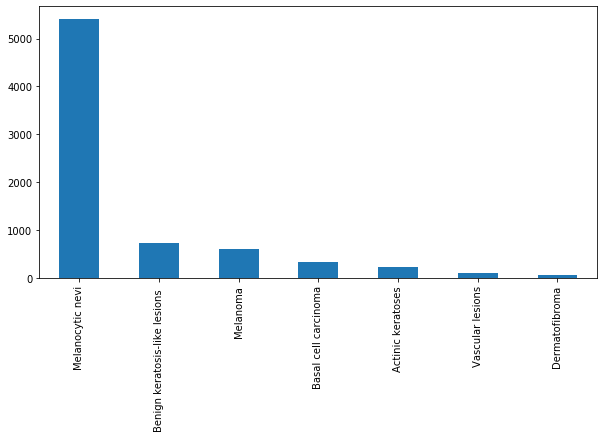

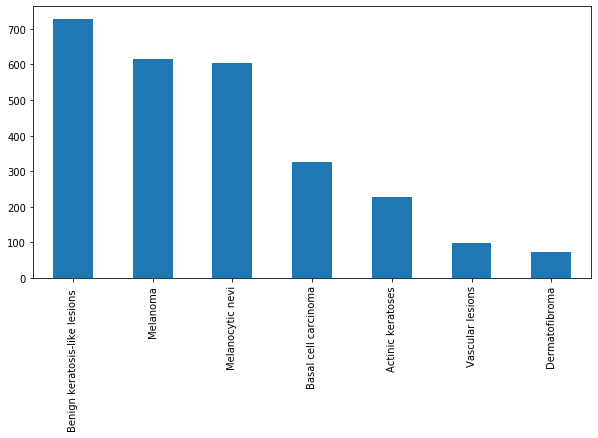

In [14]:
#"Exploratory data analysis"
# Let's see the distribution of different cell types

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

# Too many melanocytic nevi - let's balance it!
tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:4800].index)
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


In [0]:
#"Import and resize images"
input_dims = (140, 140)
input_shape = input_dims + (3,) 

In [16]:
# Load in all of the images into memory - this will take a while.  
# We also do a resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow
tic=timeit.default_timer()
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))
toc=timeit.default_timer()
print('Time taken to load images:',toc-tic)

Time taken to load images: 1048.9942935939998


In [17]:
tile_df=tile_df.reset_index(drop='True')
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,image_name,path,image_extenction,image
0,HAM_0001359,ISIC_0024312,bkl,histo,75.0,male,lower extremity,Benign keratosis-like lesions,2,ISIC_0024312.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,"[[[172, 135, 169], [174, 140, 173], [179, 144,..."
1,HAM_0002450,ISIC_0024318,df,consensus,65.0,female,lower extremity,Dermatofibroma,3,ISIC_0024318.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,"[[[226, 176, 167], [232, 178, 168], [229, 169,..."
2,HAM_0002493,ISIC_0024323,mel,histo,50.0,male,lower extremity,Melanoma,5,ISIC_0024323.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,"[[[140, 96, 85], [139, 96, 87], [142, 99, 90],..."
3,HAM_0000351,ISIC_0024324,bkl,histo,85.0,male,back,Benign keratosis-like lesions,2,ISIC_0024324.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,"[[[164, 147, 166], [167, 148, 170], [164, 146,..."
4,HAM_0002954,ISIC_0024329,akiec,histo,75.0,female,lower extremity,Actinic keratoses,0,ISIC_0024329.jpg,/content/drive/My Drive/GoogleDrive20180110/Do...,jpg,"[[[168, 138, 128], [166, 138, 126], [171, 139,..."


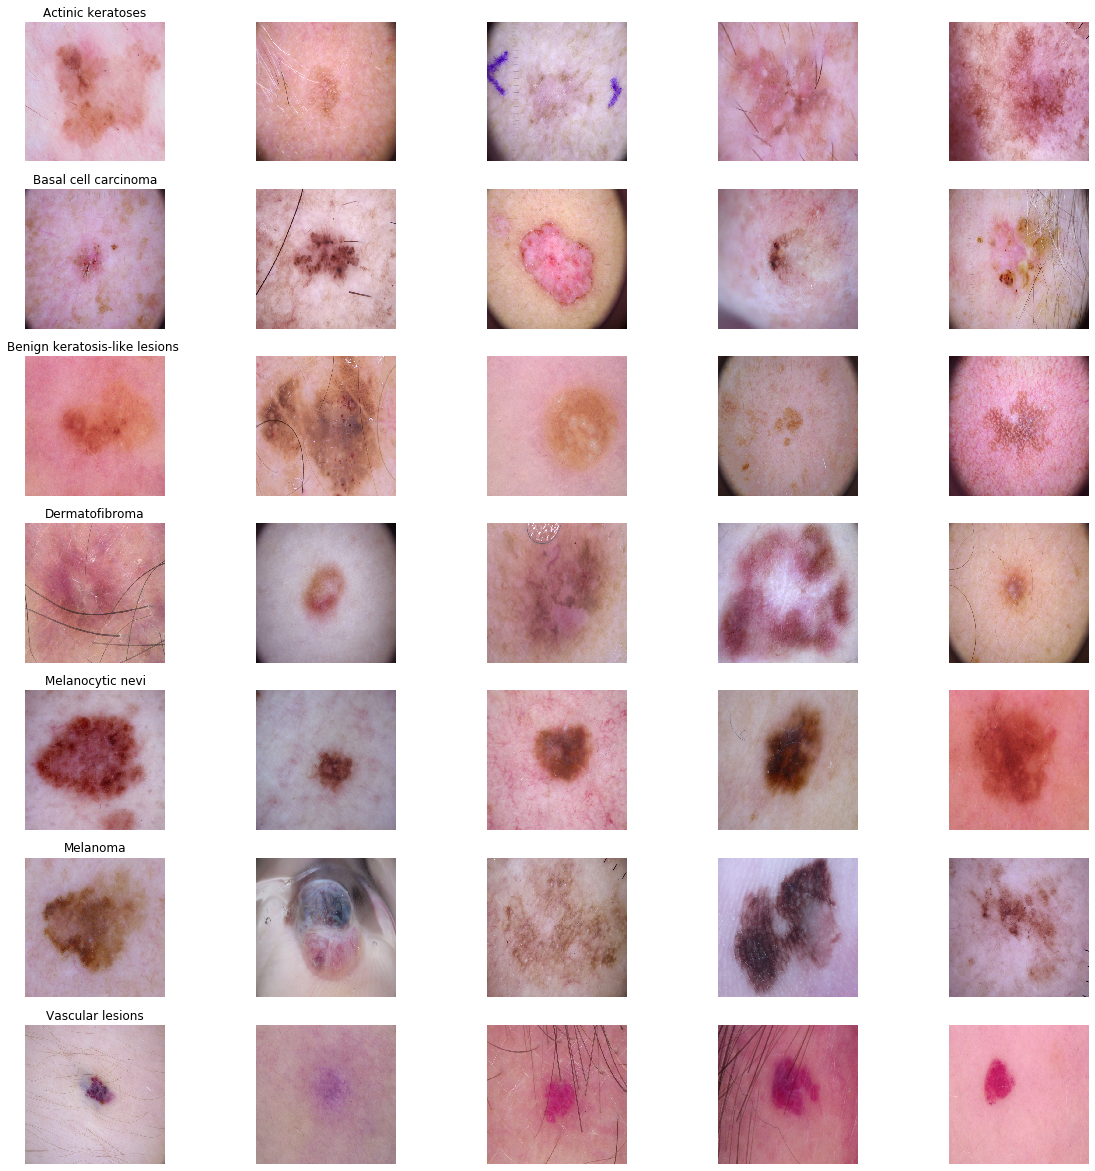

In [18]:
#"Seeing is believing"
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [19]:
# See the image size distribution - should just return one row (all images are uniform)
tile_df['image'].map(lambda x: x.shape).value_counts()

(140, 140, 3)    2670
Name: image, dtype: int64

In [0]:
#"Deep Convolutional Classifier"
#"Create train and test set"

# Shuffle the initial dataset
# tile_df = tile_df.sample(frac=1)

# # Training and test set division
# train = tile_df[:-500]
# test = tile_df[-500:]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tile_df['image'].tolist(),
                                                    tile_df['cell_type_idx'],
                                                    test_size=0.20)


# #"Assign data structures"
x_train=np.asarray(x_train)
x_test=np.asarray(x_test)
# x_train = np.asarray(train['image'].tolist()).reshape((train.shape[0],)+input_shape) #/ 255
# x_test = np.asarray(test['image'].tolist()).reshape((test.shape[0],)+input_shape) #/ 255

# y_train = train['cell_type_idx']
# y_test = test['cell_type_idx']

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)





In [42]:
x_train.shape

(2136, 140, 140, 3)

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True, 
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(x_train)

In [0]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate

In [50]:

num_classes = 7

model1 = Sequential()

model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model1.summary()


batch_size = 16
real_data_epochs = 12
gen_data_epochs = 10

history = model1.fit_generator( 
        generator=datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train) // gen_data_epochs,
        epochs=gen_data_epochs,
        verbose=1,
        validation_data=(x_test, y_test))

score = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 138, 138, 64)      1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 138, 138, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 69, 69, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 67, 67, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 34848)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

Text(0, 0.5, 'Fraction classified incorrectly')

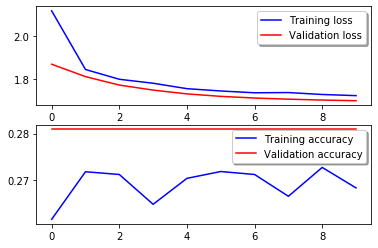

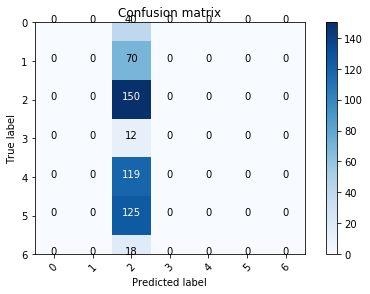

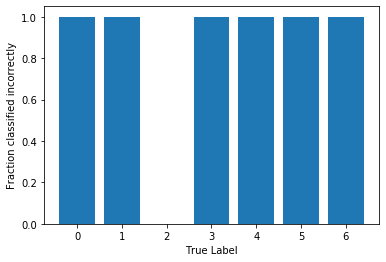

In [51]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#"Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred_Model1 = model1.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred_Model1,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plt.figure(4)
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


#"How much each class is correct"

label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)

plt.figure(5)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')